In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

2025-04-26 19:42:41.581785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745696561.836860      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745696561.910281      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load GloVe model (50-dimensional)
word2vec_model = api.load("glove-wiki-gigaword-50")
embedding_dim = 50

[==================================================] 100.0% 66.0/66.0MB downloaded


In [3]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

In [4]:
# Load raw IMDB dataset (already tokenized to integers)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

word_index = imdb.get_word_index()
index_word = {v+3: k for k, v in word_index.items()}
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"

# Convert integers back to text
texts_train = [' '.join([index_word.get(i, '') for i in x]) for x in x_train]
texts_test = [' '.join([index_word.get(i, '') for i in x]) for x in x_test]

# نظف النصوص
texts_train = [clean_text(text) for text in texts_train]
texts_test = [clean_text(text) for text in texts_test]

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Tokenizer for our own vocab
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts_train)

x_train_seq = tokenizer.texts_to_sequences(texts_train)
x_test_seq = tokenizer.texts_to_sequences(texts_test)

max_len = 400
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)

# Build embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]


In [6]:
# Build CNN model
def build_model(kernel_sizes, num_words, embedding_dim, embedding_matrix, max_len):
    inp = Input(shape=(max_len,))
    x = Embedding(input_dim=num_words,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_len,
                  trainable=False)(inp)
    
    convs = []
    for size in kernel_sizes:
        conv = Conv1D(filters=100, kernel_size=size, activation='relu')(x)
        pool = GlobalMaxPooling1D()(conv)
        convs.append(pool)
    
    merged = Concatenate()(convs)
    drop = Dropout(0.5)(merged)
    out = Dense(1, activation='sigmoid')(drop)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [7]:
# Train models with different kernel sizes
kernel_sets = [(2, 3, 4), (3, 4, 5), (4, 5, 6)]
histories = []
accuracies = []

for ks in kernel_sets:
    print(f"Training for kernel sizes: {ks}")
    model = build_model(ks, num_words, embedding_dim, embedding_matrix, max_len)
    history = model.fit(x_train_pad, y_train, batch_size=128, epochs=10, validation_split=0.2, verbose=1)
    score = model.evaluate(x_test_pad, y_test, verbose=0)
    histories.append(history)
    accuracies.append(score[1])
    print("----------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------")
    


Training for kernel sizes: (2, 3, 4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-26 19:43:34.843908: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.5731 - loss: 0.8105 - val_accuracy: 0.7468 - val_loss: 0.5261
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.7152 - loss: 0.5521 - val_accuracy: 0.8000 - val_loss: 0.4546
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.7740 - loss: 0.4744 - val_accuracy: 0.8110 - val_loss: 0.4253
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.8048 - loss: 0.4324 - val_accuracy: 0.8198 - val_loss: 0.4094
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.8071 - loss: 0.4203 - val_accuracy: 0.8246 - val_loss: 0.3978
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8211 - loss: 0.3931 - val_accuracy: 0.8266 - val_loss: 0.3907
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.8332 - loss: 0.3797 - val_accuracy: 0.8308 - val_loss: 0.3835
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - accuracy: 0.8386 - loss: 0

In [8]:
# Print test accuracies
print("\nTest Accuracies:")
for i, ks in enumerate(kernel_sets):
    print(f"Kernel Sizes {ks} - Test Accuracy: {accuracies[i]:.4f}")

# Identify and print the best model
best_idx = np.argmax(accuracies)
print(f"\nBest Model => Kernel Sizes {kernel_sets[best_idx]} with Test Accuracy {accuracies[best_idx]:.4f}")



Test Accuracies:
Kernel Sizes (2, 3, 4) - Test Accuracy: 0.8315
Kernel Sizes (3, 4, 5) - Test Accuracy: 0.8295
Kernel Sizes (4, 5, 6) - Test Accuracy: 0.8214

Best Model => Kernel Sizes (2, 3, 4) with Test Accuracy 0.8315


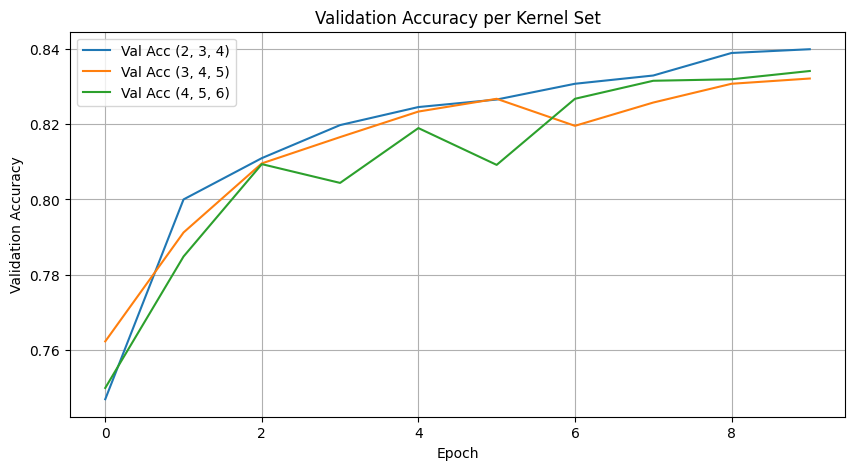

In [9]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
for i, ks in enumerate(kernel_sets):
    plt.plot(histories[i].history['val_accuracy'], label=f'Val Acc {ks}')
plt.title("Validation Accuracy per Kernel Set")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
